# --------------------------APPLIED DATA SCIENCE CAPSTONE PROJECT--------------------------

# Use Unsupervised Machine Learning Technology to Determine the Best Community in Chicago for Opening a Steakhouse

## 0. Preparation - Install & import Python packages, libraries, and modules

In [1]:
# Import necessary libraries.
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Import matplotlib and associated plotting modules.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import sklearn modules and associated metrics for UML-KMeans Clustering and determine the optimal number of clusters.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print('Libraries 1 imported.')

Libraries 1 imported.


## 1. Obtaining Chicago Community Data - Get community data table via Wikipedia, add geographical coordinates, scrape and clean the table

In [2]:
# Get the Chicago community table from Wikipedia, scrape it and create a dataframe.

df_read_1 = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago', match='Name', flavor='bs4', header=[0])
df_1 = pd.DataFrame(data=df_read_1[0])
df_1.head(10)

,Number[8],Name[8],2017 population[9],Area (sq mi.)[10],Area (km2),2017 populationdensity (/sq mi.),2017 populationdensity (/km2)
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50
4,05,North Center,35789,2.05,5.31,17458.05,6740.59
5,06,Lake View,100470,3.12,8.08,32201.92,12433.23
6,07,Lincoln Park,67710,3.16,8.18,21427.22,8273.10
7,08,Near North Side,88893,2.74,7.10,32442.70,12526.20
8,09,Edison Park,11605,1.13,2.93,4235.40,1635.30
9,10,Norwood Park,37089,4.37,11.32,8487.19,3276.92


In [3]:
# Install GeoPy and import Nominatim. These will be used to obtain the targets' geographical coordinates.

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

print('Libraries 2 imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |           1_llvm           5 KB  conda-forge
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    _pytorch_select-0.2        |            gpu_0           2 KB
    absl-py-0.12.0             |     pyhd8ed1ab_0          96 KB  conda-forge
    aiohttp-3.7.4              |   py37h5e8e339_0         

prometheus_client-0. | 46 KB     | ##################################### | 100% 
cryptography-3.4.7   | 1.1 MB    | ##################################### | 100% 
testpath-0.4.4       | 85 KB     | ##################################### | 100% 
pyrsistent-0.17.3    | 89 KB     | ##################################### | 100% 
ipython_genutils-0.2 | 21 KB     | ##################################### | 100% 
expat-2.3.0          | 168 KB    | ##################################### | 100% 
wcwidth-0.2.5        | 33 KB     | ##################################### | 100% 
cycler-0.10.0        | 9 KB      | ##################################### | 100% 
mkl-2020.4           | 215.6 MB  | ##################################### | 100% 
lcms2-2.12           | 443 KB    | ##################################### | 100% 
scikit-learn-0.24.2  | 7.5 MB    | ##################################### | 100% 
libevent-2.1.10      | 1.1 MB    | ##################################### | 100% 
charls-2.2.0         | 138 K

traitlets-5.0.5      | 81 KB     | ##################################### | 100% 
brunsli-0.1          | 200 KB    | ##################################### | 100% 
oauthlib-3.0.1       | 82 KB     | ##################################### | 100% 
retrying-1.3.3       | 11 KB     | ##################################### | 100% 
notebook-6.3.0       | 6.1 MB    | ##################################### | 100% 
backports.functools_ | 9 KB      | ##################################### | 100% 
requests-oauthlib-1. | 21 KB     | ##################################### | 100% 
ibm-wsrt-py37main-ma | 2 KB      | ##################################### | 100% 
py-1.10.0            | 73 KB     | ##################################### | 100% 
widgetsnbextension-3 | 1.8 MB    | ##################################### | 100% 
pandas-1.2.4         | 11.8 MB   | ##################################### | 100% 
tensorboard-1.14.0   | 3.2 MB    | ##################################### | 100% 
fastcache-1.1.0      | 30 KB

In [4]:
# Get Chicago geographical coordinates.

address = 'Chicago, IL'

geolocator = Nominatim(user_agent="CHI_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [5]:
# Install geocoder to get geo coordinates for communities.

!pip install geocoder
import geocoder

print('Libraries 3 imported.')

     |████████████████████████████████| 98 kB 11.7 MB/s eta 0:00:01
Libraries 3 imported.


In [6]:
# Get geographical coordinates for all 77 communities.

df_1['Latitude'] = None
df_1['Longitude'] = None

for i, comm in enumerate(df_1['Name[8]']):
    lat_long = None
    
    while(lat_long is None):
        g = geocoder.arcgis('{}, Chicago, IL'.format(comm))
        lat_long = g.latlng
    
    if lat_long:
        latitude = lat_long[0]
        longitude = lat_long[1]
    
    df_1.loc[i, 'Latitude'] = latitude
    df_1.loc[i, 'Longitude'] = longitude

df_1.head(10)

,Number[8],Name[8],2017 population[9],Area (sq mi.)[10],Area (km2),2017 populationdensity (/sq mi.),2017 populationdensity (/km2),Latitude,Longitude
0,01,Rogers Park,55062,1.84,4.77,29925.00,11554.11,42.009,-87.6662
1,02,West Ridge,76215,3.53,9.14,21590.65,8336.20,41.9995,-87.6927
2,03,Uptown,57973,2.32,6.01,24988.36,9648.06,41.9654,-87.6694
3,04,Lincoln Square,41715,2.56,6.63,16294.92,6291.50,41.9758,-87.6891
4,05,North Center,35789,2.05,5.31,17458.05,6740.59,41.9541,-87.6814
5,06,Lake View,100470,3.12,8.08,32201.92,12433.23,41.9398,-87.6568
6,07,Lincoln Park,67710,3.16,8.18,21427.22,8273.10,41.9218,-87.6474
7,08,Near North Side,88893,2.74,7.10,32442.70,12526.20,41.9003,-87.6343
8,09,Edison Park,11605,1.13,2.93,4235.40,1635.30,42.0079,-87.814
9,10,Norwood Park,37089,4.37,11.32,8487.19,3276.92,41.9857,-87.8066


In [7]:
# Rename useful columns and drop unnecessary columns.

df_2 = df_1.rename(columns={'Name[8]': 'Community','2017 population[9]': 'Population','Area (sq mi.)[10]': 'Area','2017 populationdensity (/sq mi.)': 'Pop_Density'})
df_2 = df_2.drop(['Number[8]', 'Area (km2)', '2017 populationdensity (/km2)'], axis=1)
df_2

,Community,Population,Area,Pop_Density,Latitude,Longitude
0,Rogers Park,55062,1.84,29925.00,42.009,-87.6662
1,West Ridge,76215,3.53,21590.65,41.9995,-87.6927
2,Uptown,57973,2.32,24988.36,41.9654,-87.6694
3,Lincoln Square,41715,2.56,16294.92,41.9758,-87.6891
4,North Center,35789,2.05,17458.05,41.9541,-87.6814
5,Lake View,100470,3.12,32201.92,41.9398,-87.6568
6,Lincoln Park,67710,3.16,21427.22,41.9218,-87.6474
7,Near North Side,88893,2.74,32442.70,41.9003,-87.6343
8,Edison Park,11605,1.13,4235.40,42.0079,-87.814
9,Norwood Park,37089,4.37,8487.19,41.9857,-87.8066


In [8]:
# Clean cosmetics for the name of one community - "The Loop":
df_2.iloc[31,0] = 'The Loop'

# Drop the Total row at the bottom of the table since it has no use in this analysis:
df_2.drop([77],inplace=True)
df_2

,Community,Population,Area,Pop_Density,Latitude,Longitude
0,Rogers Park,55062,1.84,29925.00,42.009,-87.6662
1,West Ridge,76215,3.53,21590.65,41.9995,-87.6927
2,Uptown,57973,2.32,24988.36,41.9654,-87.6694
3,Lincoln Square,41715,2.56,16294.92,41.9758,-87.6891
4,North Center,35789,2.05,17458.05,41.9541,-87.6814
5,Lake View,100470,3.12,32201.92,41.9398,-87.6568
6,Lincoln Park,67710,3.16,21427.22,41.9218,-87.6474
7,Near North Side,88893,2.74,32442.70,41.9003,-87.6343
8,Edison Park,11605,1.13,4235.40,42.0079,-87.814
9,Norwood Park,37089,4.37,8487.19,41.9857,-87.8066


In [9]:
# Install Python folium package for visualization.

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

print('Libraries 4 imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::pytorch==1.8.0=cpu_py37ha70c682_1
  - defaults/noarch::ibm-wsrt-py37main-keep==0.0.0=2155
  - defaults/noarch::ibm-wsrt-py37main-main==custom=2155
done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    -

In [10]:
# Create map of Chicago communities using their latitude and longitude values.

map_chicago = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map.
for lat, lng, community in zip(df_2['Latitude'], df_2['Longitude'], df_2['Community']):
    label = '{}'.format(community)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

### In case the Chicago Community Folium Map image can't load for security setting reasons, you can refer to Figure 3 in my submitted Final Report.

## 2. Segmenting Chicago Communities - Get venue information via Foursquare API, analyze venue distribution within each community

In [10]:
# Initiate Foursquare API credentials and default venue limit.

CLIENT_ID = 'WTOS2CZA2LZUQZSCNKBPO3TMIISBWIOCPMJHO40MFVRW3AFW' 
CLIENT_SECRET = 'L3UOQEAICAR5YQBUG1LVXX0HRZBNHSSYF5N1GI4VQDXBIAZZ' 
VERSION = '20180605'
LIMIT = 300

print('Foursquare API Credentials are:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('VERSION: ' + VERSION)
print('LIMIT:', LIMIT)

Foursquare API Credentials are:
CLIENT_ID: WTOS2CZA2LZUQZSCNKBPO3TMIISBWIOCPMJHO40MFVRW3AFW
CLIENT_SECRET:L3UOQEAICAR5YQBUG1LVXX0HRZBNHSSYF5N1GI4VQDXBIAZZ
VERSION: 20180605
LIMIT: 300


In [11]:
# Define a function to find the venues in any community or neighborhood.

LIMIT = 300

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
# Apply function to find the venues in chicgao communities.

chicago_nearby_venues = getNearbyVenues(names=df_2['Community'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

chicago_nearby_venues.head(10)

Rogers Park
West Ridge
Uptown
Lincoln Square
North Center
Lake View
Lincoln Park
Near North Side
Edison Park
Norwood Park
Jefferson Park
Forest Glen
North Park
Albany Park
Portage Park
Irving Park
Dunning
Montclare
Belmont Cragin
Hermosa
Avondale
Logan Square
Humboldt Park
West Town
Austin
West Garfield Park
East Garfield Park
Near West Side
North Lawndale
South Lawndale
Lower West Side
The Loop
Near South Side
Armour Square
Douglas
Oakland
Fuller Park
Grand Boulevard
Kenwood
Washington Park
Hyde Park
Woodlawn
South Shore
Chatham
Avalon Park
South Chicago
Burnside
Calumet Heights
Roseland
Pullman
South Deering
East Side
West Pullman
Riverdale
Hegewisch
Garfield Ridge
Archer Heights
Brighton Park
McKinley Park
Bridgeport
New City
West Elsdon
Gage Park
Clearing
West Lawn
Chicago Lawn
West Englewood
Englewood
Greater Grand Crossing
Ashburn
Auburn Gresham
Beverly Hills
Washington Heights
Mount Greenwood
Morgan Park
O'Hare
Edgewater


,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rogers Park,42.00897,-87.66619,Morse Fresh Market,42.008087,-87.667041,Grocery Store
1,Rogers Park,42.00897,-87.66619,Rogers Park Social,42.007360,-87.666265,Bar
2,Rogers Park,42.00897,-87.66619,Lifeline Theatre,42.007372,-87.666284,Theater
3,Rogers Park,42.00897,-87.66619,Mayne Stage,42.007975,-87.665140,Concert Hall
4,Rogers Park,42.00897,-87.66619,J.B. Alberto's Pizza,42.007941,-87.665066,Pizza Place
5,Rogers Park,42.00897,-87.66619,Rogers Park Provisions,42.007528,-87.666193,Gift Shop
6,Rogers Park,42.00897,-87.66619,The Common Cup,42.007797,-87.667901,Coffee Shop
7,Rogers Park,42.00897,-87.66619,Glenwood Sunday Market,42.008525,-87.666251,Farmers Market
8,Rogers Park,42.00897,-87.66619,The Glenwood,42.008502,-87.666273,Bar
9,Rogers Park,42.00897,-87.66619,Smack Dab,42.009291,-87.666201,Bakery


In [18]:
# Analyze each community uing onehot encoding.

chicago_onehot = pd.get_dummies(chicago_nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# Add Community column back to dataframe 
chicago_onehot['Community'] = chicago_nearby_venues['Community']   

# Move Community column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head(10)

,Community,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Bookstore,College Cafeteria,College Gym,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,National Park,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Train Station,Transportation Service,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Rogers Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
# Group rows by community and mean frequency.

chicago_grouped = chicago_onehot.groupby('Community').mean().reset_index()

chicago_grouped.head(10)

,Community,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Carpet Store,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Bookstore,College Cafeteria,College Gym,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Exhibit,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundromat,Light Rail Station,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,National Park,New American Restaurant,Nightclub,Non-Profit,Noodle House,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Train Station,Transportation Service,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000

In [20]:
# Define function to sort venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
# Get top ten venues for each community.

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues.
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe.
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['Community'] = chicago_grouped['Community']

for ind in np.arange(chicago_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted.head(10)

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Karaoke Bar,Bank,Taco Place,Seafood Restaurant,Park,Dive Bar,Discount Store,Grocery Store,Korean Restaurant
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Pharmacy,Bar,Bank,Gas Station,Sandwich Place,Candy Store,Gym / Fitness Center
2,Armour Square,American Restaurant,Bar,Asian Restaurant,Business Service,Sandwich Place,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,College Rec Center
3,Ashburn,Home Service,Light Rail Station,Automotive Shop,Pizza Place,Construction & Landscaping,Cosmetics Shop,Nightclub,Optical Shop,Office,Noodle House
4,Auburn Gresham,Park,Discount Store,Basketball Court,Convenience Store,ATM,Nightclub,Optical Shop,Office,Noodle House,Non-Profit
5,Austin,Bus Station,Park,Intersection,Liquor Store,Grocery Store,Train Station,Gym,Donut Shop,ATM,Wings Joint
6,Avalon Park,Pizza Place,Burger Joint,Fast Food Restaurant,Boutique,ATM,Grocery Store,Diner,Cajun / Creole Restaurant,Sandwich Place,Food
7,Avondale,Food Truck,Park,Chinese Restaurant,Gym,Road,Rental Car Location,Storage Facility,Sandwich Place,Supermarket,Bar
8,Belmont Cragin,Mexican Restaurant,Pizza Place,Grocery Store,Theater,Café,Laundromat,Field,Currency Exchange,Latin American Restaurant,Chinese Restaurant
9,Beverly Hills,Flower Shop,Coffee Shop,Park,Platform,Pizza Place,Dessert Shop,New American Restaurant,Office,Noodle House,Non-Profit


## 3. Clustering Chicago Communities - Determine optimal # of clusters, perform community clustering using Unsupervised Machine Learning technology - KMeans

In [26]:
# Choose the optimal number of clusters using silhouette score.

Repetition = [1, 2, 3, 4, 5]

k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in Repetition:

    chicago_cluster = chicago_grouped.drop('Community', 1)
    score=[]
    print('Silhouette Scores for Repetition #',i, 'are:')
        
    for n_cluster in k:
        kmeans = KMeans(n_clusters=n_cluster).fit(chicago_cluster)
        silhouette_avg = silhouette_score(chicago_cluster, kmeans.labels_)
        score.append(silhouette_score(chicago_cluster, kmeans.labels_))   
        print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
    
    # Option 1 - In case plotting fails (sometimes it happens due to a knowm bug in the matplotlib installation), we can print the needed information instead.  
    print('The maximum silhouette score for Repetition #',i, 'is:', max(score), '\n')
    
    # Option 2 - Plot clustering scenarios
    #print('\nPlot of Silhouette Scores vs. Value of K for Repetition #',i, 'is:')
    #plt.plot(k, score, 'o-')
    #plt.xlabel("Value for k")
    #plt.ylabel("Silhouette score")
    #plt.show()

Silhouette Scores for Repetition # 1 are:
Silhouette Score for 2 Clusters: 0.2751
Silhouette Score for 3 Clusters: 0.3694
Silhouette Score for 4 Clusters: 0.0709
Silhouette Score for 5 Clusters: 0.0920
Silhouette Score for 6 Clusters: 0.0889
Silhouette Score for 7 Clusters: 0.1265
Silhouette Score for 8 Clusters: 0.0704
Silhouette Score for 9 Clusters: 0.0690
Silhouette Score for 10 Clusters: 0.0872
The maximum silhouette score for Repetition # 1 is: 0.3694471797332873 

Silhouette Scores for Repetition # 2 are:
Silhouette Score for 2 Clusters: 0.2615
Silhouette Score for 3 Clusters: 0.2639
Silhouette Score for 4 Clusters: 0.0703
Silhouette Score for 5 Clusters: 0.0988
Silhouette Score for 6 Clusters: 0.1001
Silhouette Score for 7 Clusters: 0.0613
Silhouette Score for 8 Clusters: 0.0793
Silhouette Score for 9 Clusters: 0.0637
Silhouette Score for 10 Clusters: 0.0570
The maximum silhouette score for Repetition # 2 is: 0.26391558077141697 

Silhouette Scores for Repetition # 3 are:
Silho

## It looks like the optimal number of clusters is 3, as it has the highest silhouette score in 4 of the 5 runs. (it has the second highest score in the other run).
### As we can see, the Silhouette Scores are different for every run, even though the same underlying dataset is used. This is because KMeans is randomized, it doesn't always give the same result. 
### It also tells us that one probbaly shouldn't rely on Silhouette only. Therefore, we'll double check using the elbow method.

Inertias for Repetition # 1 are:
Inertia for 2 Clusters:  8.047845631061675
Inertia for 3 Clusters:  7.086421088871777
Inertia for 4 Clusters:  6.810990651751216
Inertia for 5 Clusters:  6.463658923508199
Inertia for 6 Clusters:  6.115086665685519
Inertia for 7 Clusters:  5.847218213079066
Inertia for 8 Clusters:  5.631331718406256
Inertia for 9 Clusters:  5.540952799020194
Inertia for 10 Clusters:  5.24683850322761

Plot of Inertias vs. Value of K for Repetition # 1 is:


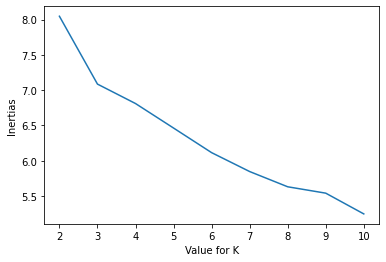

Inertias for Repetition # 2 are:
Inertia for 2 Clusters:  8.047845631061675
Inertia for 3 Clusters:  7.086421088871777
Inertia for 4 Clusters:  6.810990651751216
Inertia for 5 Clusters:  6.463658923508199
Inertia for 6 Clusters:  6.115086665685519
Inertia for 7 Clusters:  5.847218213079066
Inertia for 8 Clusters:  5.631331718406256
Inertia for 9 Clusters:  5.540952799020194
Inertia for 10 Clusters:  5.24683850322761

Plot of Inertias vs. Value of K for Repetition # 2 is:


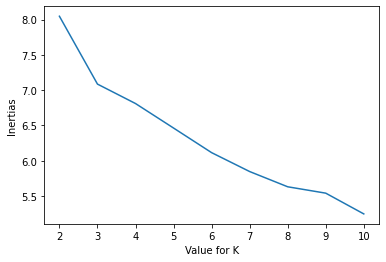

Inertias for Repetition # 3 are:
Inertia for 2 Clusters:  8.047845631061675
Inertia for 3 Clusters:  7.086421088871777
Inertia for 4 Clusters:  6.810990651751216
Inertia for 5 Clusters:  6.463658923508199
Inertia for 6 Clusters:  6.115086665685519
Inertia for 7 Clusters:  5.847218213079066
Inertia for 8 Clusters:  5.631331718406256
Inertia for 9 Clusters:  5.540952799020194
Inertia for 10 Clusters:  5.24683850322761

Plot of Inertias vs. Value of K for Repetition # 3 is:


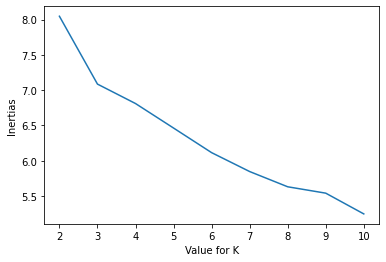

Inertias for Repetition # 4 are:
Inertia for 2 Clusters:  8.047845631061675
Inertia for 3 Clusters:  7.086421088871777
Inertia for 4 Clusters:  6.810990651751216
Inertia for 5 Clusters:  6.463658923508199
Inertia for 6 Clusters:  6.115086665685519
Inertia for 7 Clusters:  5.847218213079066
Inertia for 8 Clusters:  5.631331718406256
Inertia for 9 Clusters:  5.540952799020194
Inertia for 10 Clusters:  5.24683850322761

Plot of Inertias vs. Value of K for Repetition # 4 is:


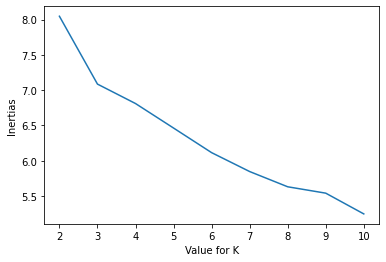

Inertias for Repetition # 5 are:
Inertia for 2 Clusters:  8.047845631061675
Inertia for 3 Clusters:  7.086421088871777
Inertia for 4 Clusters:  6.810990651751216
Inertia for 5 Clusters:  6.463658923508199
Inertia for 6 Clusters:  6.115086665685519
Inertia for 7 Clusters:  5.847218213079066
Inertia for 8 Clusters:  5.631331718406256
Inertia for 9 Clusters:  5.540952799020194
Inertia for 10 Clusters:  5.24683850322761

Plot of Inertias vs. Value of K for Repetition # 5 is:


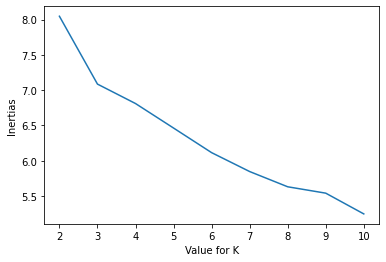

In [53]:
# Choose the optimal number of clusters using elbow method and inertia.

Repetition = [1, 2, 3, 4, 5]

k = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for j in Repetition:

    inertias = []
    print('Inertias for Repetition #',j, 'are:')
    
    for i in k:
        kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=47).fit(chicago_cluster)
        inertias.append(kmeans.inertia_)        
        print('Inertia for',i, 'Clusters: ', kmeans.inertia_)
        
    # plot clustering scenarios 
    print('\nPlot of Inertias vs. Value of K for Repetition #',j, 'is:')
    plt.plot(k, inertias)
    plt.xlabel("Value for K")
    plt.ylabel("Inertias")
    plt.show()


### The elbow point is determined where the rate of decrease sharply shifts. The sharpest change in slope (i.e., the elbow) occurs at k = 3 in all 5 runs. 
### As we can see, the inertia plottings are identical for all 5 runs. This is because inertia is a function of the underlying dataset and not randomized. If the inertia plot is sufficiently indicative, we can rely on it.

## At this point, we can conclude that the optimal number of clusters is 3, since it has the highest silhouette score as well as the best inertia profile.

In [23]:
# Cluster the commnunities using KMeans with the obtained optimal cluster number 3.

chicago_cluster = chicago_grouped.drop('Community', 1)

k_clusters = 3
kmeans = KMeans(n_clusters=k_clusters, init='k-means++', random_state=42).fit(chicago_cluster)

# Check cluster labels generated for each row in the dataframe.
kmeans.labels_[0:30] 


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [24]:
# Add clustering labels to dataframe.
community_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_merged = df_2

# Merge chicago_grouped with community_venues_sorted to add latitude/longitude for each community.
chicago_merged = chicago_merged.join(community_venues_sorted.set_index('Community'), on='Community', how='right')
chicago_merged['Cluster Labels'] = chicago_merged['Cluster Labels'].astype(int)

# Check the Cluster Labels column.
chicago_merged.head(10)


,Community,Population,Area,Pop_Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Albany Park,51992,1.92,27079.17,41.96829,-87.72338,1,Mexican Restaurant,Karaoke Bar,Bank,Taco Place,Seafood Restaurant,Park,Dive Bar,Discount Store,Grocery Store,Korean Restaurant
56,Archer Heights,13142,2.01,6538.31,41.81154,-87.72556,1,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Pharmacy,Bar,Bank,Gas Station,Sandwich Place,Candy Store,Gym / Fitness Center
33,Armour Square,13455,1.00,13455.00,41.83458,-87.63189,1,American Restaurant,Bar,Asian Restaurant,Business Service,Sandwich Place,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,College Rec Center
69,Ashburn,43792,4.86,9010.70,41.74785,-87.70995,1,Home Service,Light Rail Station,Automotive Shop,Pizza Place,Construction & Landscaping,Cosmetics Shop,Nightclub,Optical Shop,Office,Noodle House
70,Auburn Gresham,46278,3.77,12275.33,41.74319,-87.65504,0,Park,Discount Store,Basketball Court,Convenience Store,ATM,Nightclub,Optical Shop,Office,Noodle House,Non-Profit
24,Austin,95260,7.15,13323.08,41.88775,-87.76363,1,Bus Station,Park,Intersection,Liquor Store,Grocery Store,Train Station,Gym,Donut Shop,ATM,Wings Joint
44,Avalon Park,9985,1.25,7988.00,41.74507,-87.58816,1,Pizza Place,Burger Joint,Fast Food Restaurant,Boutique,ATM,Grocery Store,Diner,Cajun / Creole Restaurant,Sandwich Place,Food
20,Avondale,37368,1.98,18872.73,41.93925,-87.71125,1,Food Truck,Park,Chinese Restaurant,Gym,Road,Rental Car Location,Storage Facility,Sandwich Place,Supermarket,Bar
18,Belmont Cragin,79910,3.91,20437.34,41.92802,-87.75384,1,Mexican Restaurant,Pizza Place,Grocery Store,Theater,Café,Laundromat,Field,Currency Exchange,Latin American Restaurant,Chinese Restaurant
71,Beverly Hills,20822,3.18,6547.80,41.71201,-87.6709,1,Flower Shop,Coffee Shop,Park,Platform,Pizza Place,Dessert Shop,New American Restaurant,Office,Noodle House,Non-Profit


In [25]:
# Create map showing Chicago community clusters.

#chicago latlong:
latitude = 41.8755616
longitude = -87.6244212

map_chicago_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chicago_merged['Latitude'], chicago_merged['Longitude'], chicago_merged['Community'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster -1],
        fill=True,
        fill_color=rainbow[cluster -1],
        fill_opacity=0.7).add_to(map_chicago_clusters)
       
map_chicago_clusters


### In case the Chicago Community Clustering Folium Map image can't load for security setting reasons, you can refer to Figure 10 in my submitted Final Report.

## Now we can analyze each cluster of communities and see if a steakhouse can be a good fit there.

In [26]:
# Cluster 0.

chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[0] + list(range(6, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Auburn Gresham,0,Park,Discount Store,Basketball Court,Convenience Store,ATM,Nightclub,Optical Shop,Office,Noodle House,Non-Profit
34,Douglas,0,Park,Bus Station,Shopping Mall,Train Station,Insurance Office,Nightclub,Optical Shop,Office,Noodle House,Non-Profit
9,Norwood Park,0,Park,Gay Bar,Bus Station,Pakistani Restaurant,Other Great Outdoors,Optical Shop,Office,Noodle House,Non-Profit,Nightclub
35,Oakland,0,Park,Public Art,Track,ATM,New American Restaurant,Office,Noodle House,Non-Profit,Nightclub,National Park


### Cluster 0 appeas to be a recreation paradise. Parks are the most popular venues. People most likely go there before or after a meal, but not for a meal. So this is not an ideal cluster for opening a steakhouse.

In [27]:
# Cluster 1.

chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[0] + list(range(6, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Albany Park,1,Mexican Restaurant,Karaoke Bar,Bank,Taco Place,Seafood Restaurant,Park,Dive Bar,Discount Store,Grocery Store,Korean Restaurant
56,Archer Heights,1,Mexican Restaurant,Mobile Phone Shop,Grocery Store,Pharmacy,Bar,Bank,Gas Station,Sandwich Place,Candy Store,Gym / Fitness Center
33,Armour Square,1,American Restaurant,Bar,Asian Restaurant,Business Service,Sandwich Place,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,College Rec Center
69,Ashburn,1,Home Service,Light Rail Station,Automotive Shop,Pizza Place,Construction & Landscaping,Cosmetics Shop,Nightclub,Optical Shop,Office,Noodle House
24,Austin,1,Bus Station,Park,Intersection,Liquor Store,Grocery Store,Train Station,Gym,Donut Shop,ATM,Wings Joint
44,Avalon Park,1,Pizza Place,Burger Joint,Fast Food Restaurant,Boutique,ATM,Grocery Store,Diner,Cajun / Creole Restaurant,Sandwich Place,Food
20,Avondale,1,Food Truck,Park,Chinese Restaurant,Gym,Road,Rental Car Location,Storage Facility,Sandwich Place,Supermarket,Bar
18,Belmont Cragin,1,Mexican Restaurant,Pizza Place,Grocery Store,Theater,Café,Laundromat,Field,Currency Exchange,Latin American Restaurant,Chinese Restaurant
71,Beverly Hills,1,Flower Shop,Coffee Shop,Park,Platform,Pizza Place,Dessert Shop,New American Restaurant,Office,Noodle House,Non-Profit
59,Bridgeport,1,Chinese Restaurant,Coffee Shop,Park,Korean Restaurant,Art Gallery,Pharmacy,Grocery Store,Bar,Mobile Phone Shop,Gas Station


### Cluster 1 appears to be a mix of everything. This cluster seems to have what it takes for a decent city life. But it's too broad, we hope to narrow down to a much smaller number of communities, or the result would make very little use. We keep this cluster as a potential candidate and move on.

In [28]:
# Cluster 2.

chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[0] + list(range(6, chicago_merged.shape[1]))]]

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Roseland,2,Intersection,ATM,Other Great Outdoors,Optical Shop,Office,Noodle House,Non-Profit,Nightclub,New American Restaurant,Pakistani Restaurant


### Cluster 2 appears to be in the middle of nowhere. This cluster only includes one community and Intersection is its most popular venue. What kind of community is this? We won't have to risk one's investment in this cluster that's full of uncertainty. 

## At this point, we have only one cluster left, that's cluster 1. We will continue to explore.

## 4. Determine the Best Chicago Community for Opening a Steakhouse

### We will examine the existing # of steakhouse and population in the communities, check their ratios, review community reputation, and determine the best candidate

In [29]:
# Create new dataFrame to show # of steakhouse per community.
chsh1 = chicago_onehot[['Community','Steakhouse']]
chsh1 = chsh1.groupby(['Community']).count()
chsh1.head(10)

,Steakhouse
Community,
Albany Park,21
Archer Heights,20
Armour Square,22
Ashburn,6
Auburn Gresham,5
Austin,13
Avalon Park,15
Avondale,31
Belmont Cragin,20


In [30]:
# reset indices to prepare for merge.
chsh2 = df_2.sort_values('Community', ascending=True).reset_index(drop=True)
chsh3 = chsh1.reset_index()

# Add population back to table and sort by # of steakhouse.
chsh4 = chsh3.join(chsh2['Population'])
chicago_sh = chsh4.sort_values('Steakhouse',ascending=True)
chicago_sh

,Community,Steakhouse,Population
60,Roseland,1,42433
62,South Deering,3,14614
53,Norwood Park,4,37089
20,East Side,4,23737
22,Edison Park,4,11605
67,Washington Heights,4,27453
12,Burnside,4,2254
51,North Lawndale,5,35947
4,Auburn Gresham,5,46278
58,Riverdale,5,7394


In [31]:
# Add cluster labels to the table and drop all cluster except cluster 1

trans = chicago_merged[['Community','Cluster Labels']]
trans_file = trans.sort_values('Community',ascending = True).reset_index(drop=True)
chicago_sh_exp = pd.concat([ chicago_sh , trans_file['Cluster Labels']], axis=1 )
chicago_sh = chicago_sh_exp[chicago_sh_exp['Cluster Labels'] == 1]
chicago_sh


,Community,Steakhouse,Population,Cluster Labels
0,Albany Park,21,51992,1
1,Archer Heights,20,13142,1
2,Armour Square,22,13455,1
3,Ashburn,6,43792,1
5,Austin,13,95260,1
6,Avalon Park,15,9985,1
7,Avondale,31,37368,1
8,Belmont Cragin,20,79910,1
9,Beverly Hills,6,20822,1
10,Bridgeport,41,33637,1


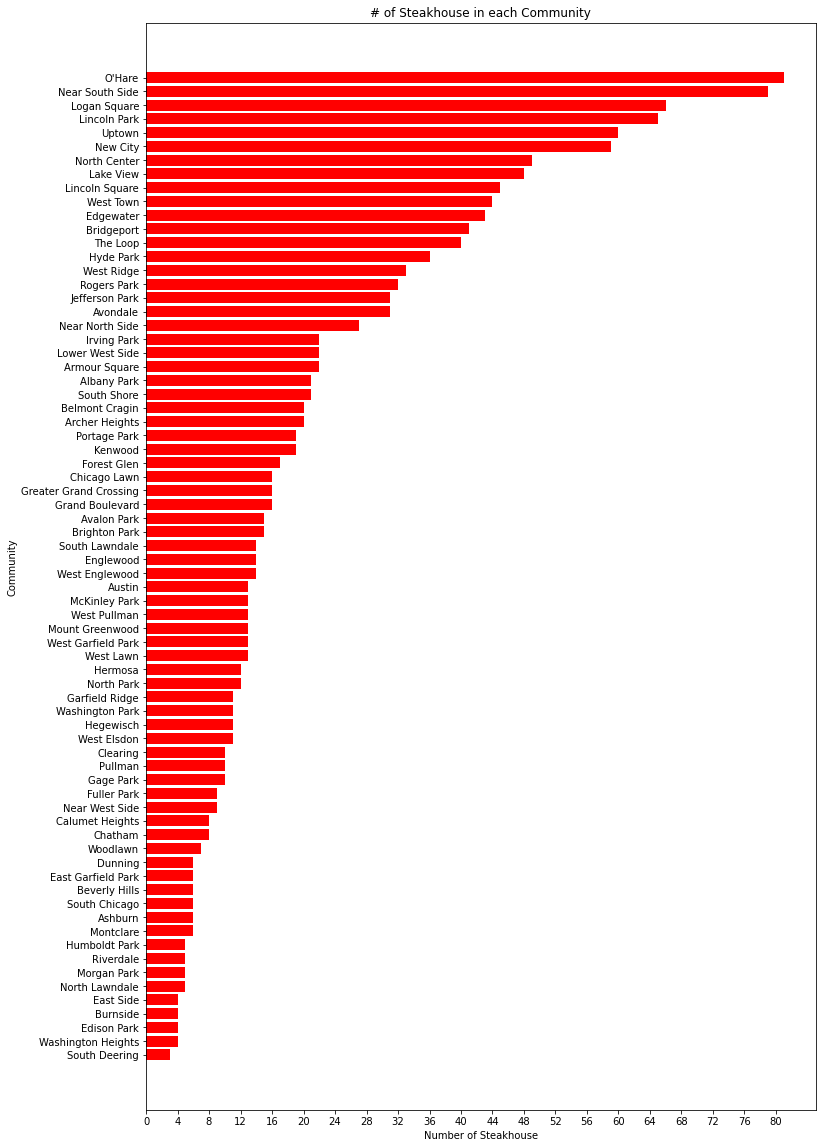

In [34]:
# Visualize # of steakhouse in each community.

fig = plt.figure(figsize=(12,20))
chicago_sh = chicago_sh.sort_values('Steakhouse', ascending = True)
y = chicago_sh['Community'].astype(str)
width = chicago_sh['Steakhouse'].astype(int)
plt.xticks(np.arange(0, 84, step=4))

plt.xlabel('Number of Steakhouse')
plt.ylabel('Community')
plt.title('# of Steakhouse in each Community')

plt.barh(y, width, height=0.8, left=None, align='center', color='red') 
plt.show()

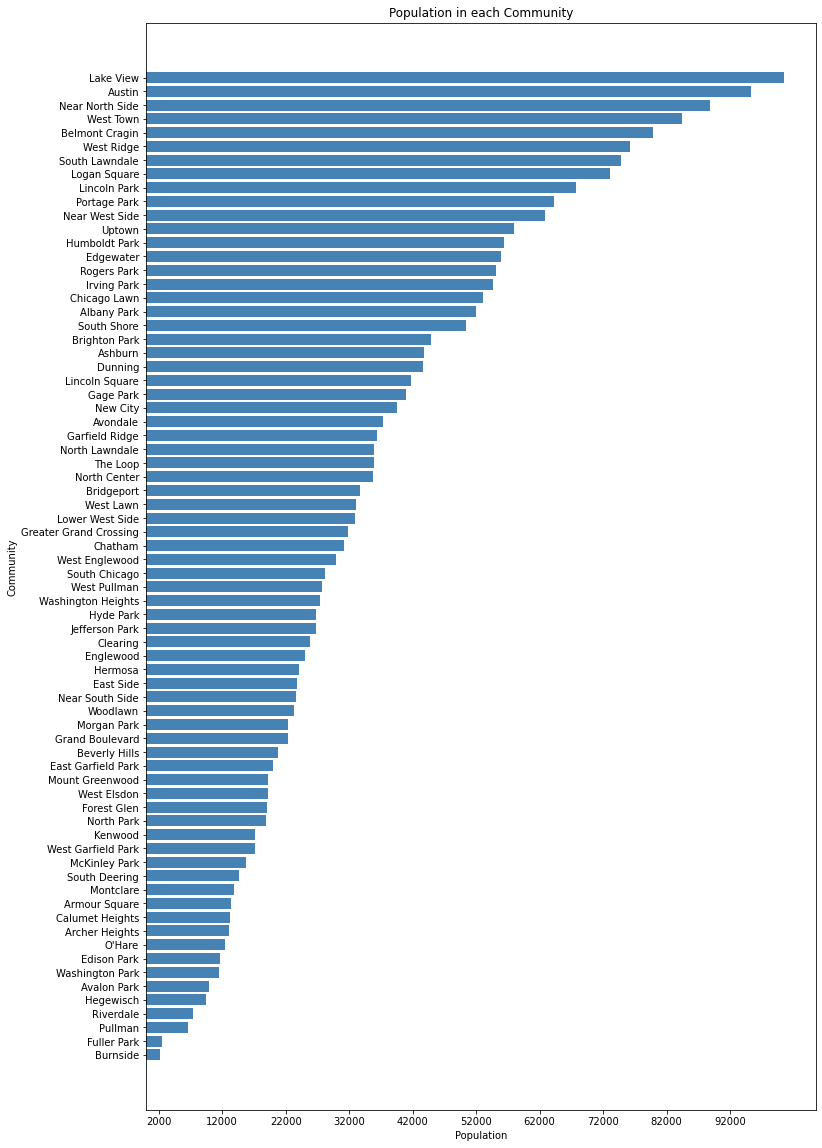

In [35]:
# Visualize population per community.

fig = plt.figure(figsize=(12,20))
chicago_sh = chicago_sh.sort_values('Population', ascending=True)
y = chicago_sh['Community'].astype(str)
width = chicago_sh['Population'].astype(int)
plt.xticks(np.arange(2000, 101000, step=10000))

plt.xlabel('Population')
plt.ylabel('Community')
plt.title('Population in each Community')

plt.barh(y, width, height=0.8, left=None, align='center', color = 'steelblue') 
plt.show()

### Our intuitive feeling is that the higher the # of steakhouse per capita in a region, the richer the region, as steakhouses are relatively high end restaurants. Let's take a closer look. For better visualization, we use the reciprocal, population per steakhouse (Pop_per_steakhouse), to examine the results.

In [36]:
# Add a calculated column (i.e., Pop_per_Steakhouse) to the table.

chicago_sh['Pop_per_Steakhouse'] = (chicago_sh['Population']/chicago_sh['Steakhouse']).astype(int)
chicago_sh.head(10)

,Community,Steakhouse,Population,Cluster Labels,Pop_per_Steakhouse
12,Burnside,4,2254,1,563
25,Fuller Park,9,2439,1,271
57,Pullman,10,6613,1,661
58,Riverdale,5,7394,1,1478
30,Hegewisch,11,9418,1,856
6,Avalon Park,15,9985,1,665
68,Washington Park,11,11502,1,1045
22,Edison Park,4,11605,1,2901
54,O'Hare,81,12377,1,152
1,Archer Heights,20,13142,1,657


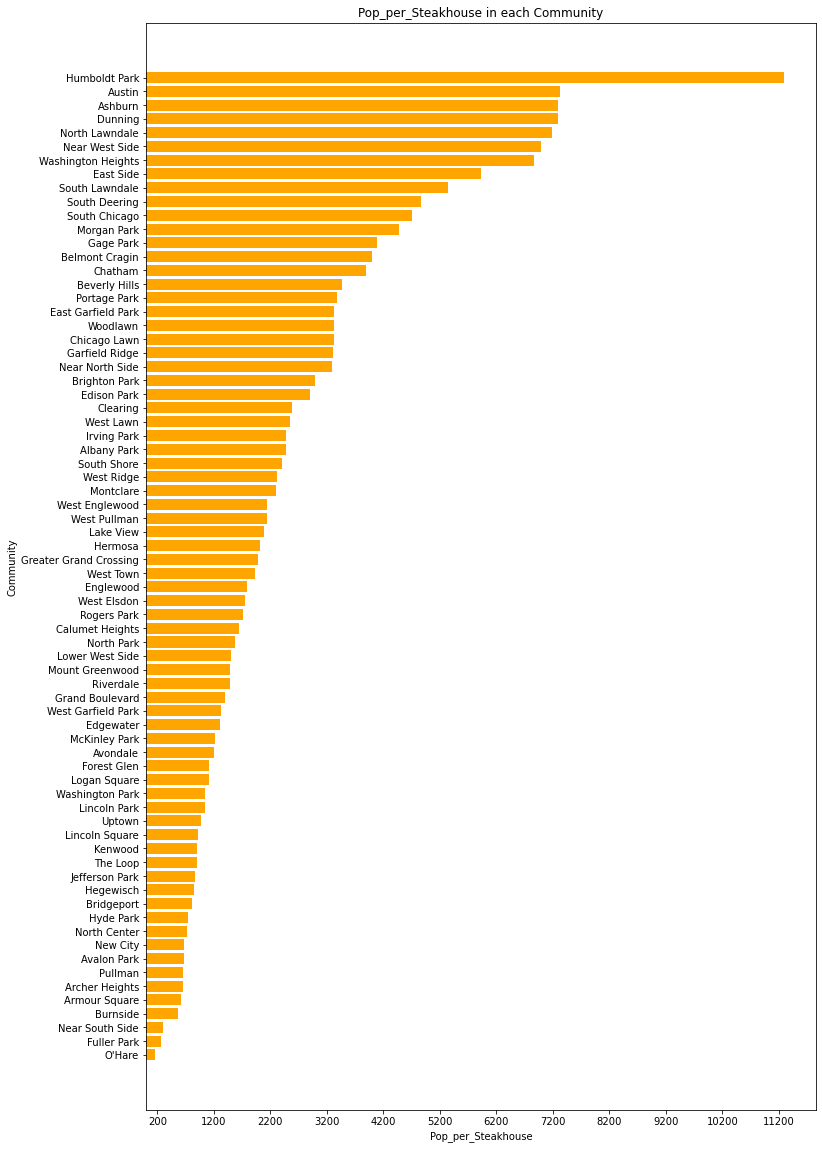

In [39]:
# Visualization

fig = plt.figure(figsize=(12,20))
chicago_sh = chicago_sh.sort_values('Pop_per_Steakhouse', ascending=True)
y = chicago_sh['Community'].astype(str)
width = chicago_sh['Pop_per_Steakhouse'].astype(int)
plt.xticks(np.arange(200, 12000, step=1000))

plt.xlabel('Pop_per_Steakhouse')
plt.ylabel('Community')
plt.title('Pop_per_Steakhouse in each Community')

plt.barh(y, width, height=0.8, left=None, align='center', color = 'orange') 
plt.show()

### Checking online community reviews such as
### (good communities):   https://theculturetrip.com/north-america/usa/illinois/articles/the-10-coolest-neighborhoods-in-chicago/
### (bad communities):   https://usaestaonline.com/most-dangerous-neighborhoods-in-chicago
### It's wise to avoid bad communities. Finally, based on community reviews, I chose 4 communities that are on the good community list.   

In [68]:
# Create a subset of the dataframe containing only the 4 good communities. 

chicago_sh_finalists = chicago_sh[chicago_sh['Community'] == 'Bridgeport'].append(chicago_sh[chicago_sh['Community'] == 'Hyde Park']).append(chicago_sh[chicago_sh['Community'] == 'Logan Square']).append(chicago_sh[chicago_sh['Community'] == 'Rogers Park'])
chicago_sh_finalists

,Community,Steakhouse,Population,Cluster Labels,Pop_per_Steakhouse
10,Bridgeport,41,33637,1,820
33,Hyde Park,36,26827,1,745
40,Logan Square,66,73046,1,1106
59,Rogers Park,32,55062,1,1720


### A simple calculation reveals that the average population per steakhouse for the 4 good communities is 1098. We want to select the community with the highest Pop_per_Steakhouse, because it most likely indicates high growth potential and less competition. This would be Rogers Park.

# Based on the systematic analysis using unsupervised machine learning KMeans clustering technology, we conclude and recommend that 
# Rogers Park community is the best location for opening a steakhouse in Chicago!